In [2]:
import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import Model
import os
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

class LPIPS_Lin(tf.keras.Model):
    def __init__(self, input_shape=(None,None, 3)):
        super().__init__()

        self.feature_extractor = self.build_feature_model(input_shape)
        self.linear_weights = []

        dummy_input = tf.zeros((1, 64, 64, 3))
        feats = self.feature_extractor(dummy_input)
        self.feature_shapes = [f.shape[1:] for f in feats]

        for feat_shape in self.feature_shapes:
            c = feat_shape[-1]
            w = tf.Variable(
                initial_value=tf.ones((1, 1, 1, c)),
                trainable=True,
                constraint=tf.keras.constraints.NonNeg()
            )
            self.linear_weights.append(w)

    def build_feature_model(self, input_shape):
        base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
        layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv4', 'block4_conv4', 'block5_conv4']
        outputs = [base_model.get_layer(name).output for name in layer_names]
        model = Model(inputs=base_model.input, outputs=outputs)
        model.trainable = False
        return model

    def channel_norm(self, x, eps=1e-10):
        norm = tf.math.sqrt(tf.reduce_sum(tf.square(x), axis=-1, keepdims=True) + eps)
        return x / norm

    def compute_lpips_distance(self, x, x0):
        x = preprocess_input(x * 255.0)
        x0 = preprocess_input(x0 * 255.0)

        x_feats = self.feature_extractor(x)
        x0_feats = self.feature_extractor(x0)

        dists = []
        for f1, f2, w in zip(x_feats, x0_feats, self.linear_weights):
            f1_norm = self.channel_norm(f1)
            f2_norm = self.channel_norm(f2)
            diff = tf.square(f1_norm - f2_norm)
            scaled_diff = diff * w
            d = tf.reduce_mean(tf.reduce_sum(scaled_diff, axis=-1), axis=[1, 2])
            dists.append(d)
        return tf.add_n(dists)  

    def call(self, x_ref, x0, x1=None):
        d0 = self.compute_lpips_distance(x_ref, x0)
        if x1 is not None:
            d1 = self.compute_lpips_distance(x_ref, x1)
            return tf.stack([d0, d1], axis=1)
        else:
            return d0

    def get_trainable_variables(self):
        return self.linear_weights


In [133]:
def lpips_loss(logits, labels):
    labels = tf.squeeze(labels)
    labels = tf.cast(labels, tf.int32)
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=-logits))

In [134]:
def load_npy_label(npy_path):
    def _load(path):
        path_str = path.decode("utf-8")
        value = np.load(path_str)
        value=value.squeeze()
        return np.array([value], dtype=np.float32)
    return tf.numpy_function(_load, [npy_path], tf.float32)

def load_triplet_flat(index, root_dir, img_size=(64, 64)):
    # Ścieżki
    ref_path   = tf.strings.join([root_dir, "ref", index + ".png"], separator=os.sep)
    p0_path    = tf.strings.join([root_dir, "p0", index + ".png"], separator=os.sep)
    p1_path    = tf.strings.join([root_dir, "p1", index + ".png"], separator=os.sep)
    judge_path = tf.strings.join([root_dir, "judge", index + ".npy"], separator=os.sep)

    def load_and_preprocess(img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, img_size)
        return img

    ref = load_and_preprocess(ref_path)
    p0 = load_and_preprocess(p0_path)
    p1 = load_and_preprocess(p1_path)

    label = load_npy_label(judge_path)  # float32 scalar, shape (1,)

    return ref, p0, p1, label

def create_flat_bapps_dataset(root_dir, img_size=(64, 64), batch_size=16, shuffle=True):
    judge_files = tf.io.gfile.glob(os.path.join(root_dir, "judge", "*.npy"))
    indices = [os.path.splitext(os.path.basename(f))[0] for f in judge_files]
    dataset = tf.data.Dataset.from_tensor_slices(indices)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(indices), reshuffle_each_iteration=True)

    dataset = dataset.map(lambda idx: load_triplet_flat(idx, root_dir, img_size),
                          num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [135]:
DATASET_ROOT = "/mnt/c/Users/komej/Downloads/BAPPS/dataset/2afc/train/mix/"

train_dataset = create_flat_bapps_dataset(
    root_dir=DATASET_ROOT,
    img_size=(64, 64),
    batch_size=16
)

#for ref, p0, p1, label in train_dataset.take(1):
    #print(ref.shape, p0.shape, p1.shape, label)

In [37]:
for ref, p0, p1, label in train_dataset.take(1):
    ref_0 = ref[0]
    p0_0 = p0[0]
    p1_1=p1[0]
    label_0 = label[0].numpy()

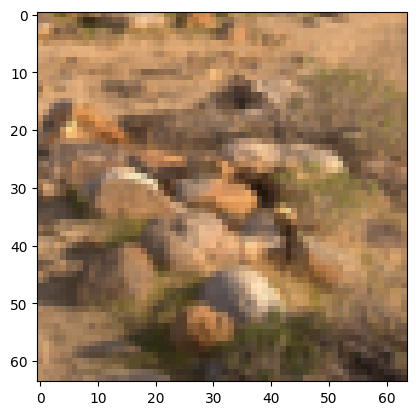

In [42]:
plt.imshow(ref_0)

In [39]:
label_0

array([[1.]], dtype=float32)

In [138]:
model = LPIPS_Lin()
optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(x_ref, x0, x1, label):
    with tf.GradientTape() as tape:
        logits = model(x_ref, x0, x1)
        loss = lpips_loss(logits, label)
    grads = tape.gradient(loss, model.get_trainable_variables())
    optimizer.apply_gradients(zip(grads, model.get_trainable_variables()))
    return loss

In [139]:
def train_loop(dataset, epochs=5):
    for epoch in range(epochs):
        print(f"\n🌀 Epoch {epoch + 1}")
        losses = []

        for step, (ref, p0, p1, label) in enumerate(dataset):
            loss = train_step(ref, p0, p1, label)
            losses.append(loss.numpy())

            if step % 50 == 0:
                print(f"Step {step} - loss: {loss.numpy():.4f}")

        print(f"✅ Epoch {epoch + 1} finished, mean loss: {sum(losses)/len(losses):.4f}")

In [140]:
train_loop(train_dataset, epochs=10)


🌀 Epoch 1
Step 0 - loss: 0.2868
Step 50 - loss: 0.4946
Step 100 - loss: 0.3537


KeyboardInterrupt: 

In [129]:
model.save("lpips_lin_model.keras")

In [130]:
model.summary()

Model: "lpips__lin_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_11 (Functional)      │ ((None, 64, 64, 64),   │    20,024,384 │
│                                 │ (None, 32, 32, 128),   │               │
│                                 │ (None, 16, 16, 256),   │               │
│                                 │ (None, 8, 8, 512),     │               │
│                                 │ (None, 4, 4, 512))     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [131]:
for i, w in enumerate(model.linear_weights):
    np.save(f"linear_weight_{i}.npy", w.numpy())